In [6]:
from utility import *
from dataset import *
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
from model_trainer import *
from model import *
from model_evaluator import *
from tqdm import tqdm

In [2]:
image_annotation_mapping = get_image_annot_mapping()
train_data, validation_data, test_data = train_test_split(image_annotation_mapping, stratify = runtime_parameters.label_column_name)
print("Data Size : ", image_annotation_mapping.shape)
print("Train Data Size : ", train_data.shape)
print("Validation Data Size : ", validation_data.shape)
print("Test Data Size : ", test_data.shape)
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(np.array(train_data[runtime_parameters.label_column_name].tolist()).reshape(-1,1))
dataset = Dataset(
    pd.concat([train_data, validation_data, test_data], axis = 0, ignore_index = True), 
    runtime_parameters.images_file_path_column,
    runtime_parameters.annotation_file_path_column,
    runtime_parameters.label_column_name, 
    onehot_encoder
)
dataloader = DataLoader(dataset, batch_size=runtime_parameters.batch_size, shuffle=True)
print("Catgories : ", len(onehot_encoder.categories_[0]))

Data Size :  (6209, 4)
Train Data Size :  (4933, 4)
Validation Data Size :  (575, 4)
Test Data Size :  (701, 4)
Catgories :  97


In [4]:
model = torch.load("VGG19_Tuned.pth", map_location=torch.device('cpu'))

In [5]:
loss_fn = ObjectDetectionLoss(97, runtime_parameters.lambda_box, runtime_parameters.lambda_cls)
model = model.to(device = runtime_parameters.device)
running_loss_test = []
images = []
actual_bboxes = []
actual_labels = []
predicted_bboxes = []
predicted_labels = []
count = 0
model.eval()
for idx, data in tqdm(enumerate(dataloader)):
    image = data["image"].to(device = runtime_parameters.device)
    bbox = data["bbox"].to(device = runtime_parameters.device)
    label = data["label"].to(device = runtime_parameters.device)

    with torch.no_grad():
        bbox_prediction, label_prediction = model(image)

        actual_label = torch.argmax(label, dim=1).cpu().numpy()
        predicted_label = torch.argmax(label_prediction, dim = 1).cpu().numpy()

        actual_bbox = bbox.cpu().numpy()
        predicted_bbox = bbox_prediction.cpu().numpy()

        images.extend(image.cpu().numpy())

        actual_labels.extend(actual_label.tolist())
        predicted_labels.extend(predicted_label.tolist())

        actual_bboxes.extend(actual_bbox.tolist())
        predicted_bboxes.extend(predicted_bbox.tolist())

        loss = loss_fn(bbox_prediction, bbox, label_prediction, label)
        running_loss_test.append(loss.item())
        if idx%10 == 0:
            print(f"\t############# [Test {idx + 1}] : Loss = {loss.item()}")
    count += 1
    break
# Evaluation Metrics ...
average_loss = sum(running_loss_test) / count
# Calculate precision, recall, and F1 score for each class
# precision_per_class = precision_score(actual_labels, predicted_labels, average=None)
# recall_per_class = recall_score(actual_labels, predicted_labels, average=None)
# f1_per_class = f1_score(actual_labels, predicted_labels, average=None)

# Calculate micro and macro averages
precision_macro = precision_score(actual_labels, predicted_labels, average='macro')
recall_macro = recall_score(actual_labels, predicted_labels, average='macro')
f1_macro = f1_score(actual_labels, predicted_labels, average='macro')

precision_micro = precision_score(actual_labels, predicted_labels, average='micro')
recall_micro = recall_score(actual_labels, predicted_labels, average='micro')
f1_micro = f1_score(actual_labels, predicted_labels, average='micro')

print(f"\n\n========================== EVALUATION OF VGG-19 ===========================\n")
print("Average Loss : ", average_loss)
# print("Precision Per Class : ", precision_per_class)
# print("Recall Per Class : ", recall_per_class)
# print("F1 Score Per Class : ", f1_per_class)

print("Precision Macro : ", precision_macro)
print("Recall Macro : ", recall_macro)
print("F1 Score Macro : ", f1_macro)

print("Precision Micro : ", precision_micro)
print("Recall Micro : ", recall_micro)
print("F1 Score Micro : ", f1_micro)

cosine_similarity_val = cosine_similarity(actual_bboxes, predicted_bboxes)
cosine_similarity_val = cosine_similarity_val[np.diag_indices(cosine_similarity_val.shape[0])]
print("Cosine Similarity of BBox : ", sum(cosine_similarity_val) / cosine_similarity_val.shape[0])
print("\n=======================================================================================\n\n")

	############# [Test 1] : Loss = 0.6538849472999573


========================== EVALUATION OF VGG-19 ===========================

Average Loss :  0.6538849472999573
Precision Macro :  0.04983022938905292
Recall Macro :  0.11764705882352941
F1 Score Macro :  0.05824427288958182
Precision Micro :  0.1953125
Recall Micro :  0.1953125
F1 Score Micro :  0.1953125
Cosine Similarity of BBox :  0.9659809230038354





C:\Users\11380\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
def visualize(image, bbox, bbox_actual, filename = "./debug.jpg"):
    # image = mpimg.imread(image_path)
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(image)
    # Create a rectangle patch for the bounding box
    bbox = patches.Rectangle(
        (float(bbox[0]), float(bbox[2])), 
        float(bbox[3] - bbox[0]), 
        float(bbox[1] - bbox[2]), 
        linewidth=2, 
        edgecolor='r', 
        facecolor='none'
    )
    # Add the bounding box to the plot
    ax.add_patch(bbox)

    bbox_actual = patches.Rectangle(
        (float(bbox_actual[0]), float(bbox_actual[2])), 
        float(bbox_actual[3] - bbox_actual[0]), 
        float(bbox_actual[1] - bbox_actual[2]), 
        linewidth=2, 
        edgecolor='orange', 
        facecolor='none'
    )
    # Add the bounding box to the plot
    ax.add_patch(bbox_actual)
    # Optionally set limits and labels
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)  # Invert y-axis to match image coordinates
    plt.title('Image with Bounding Box')
    plt.axis('off')  # Hide axes
    # Show the plot
    plt.show()
    # plt.savefig(filename)

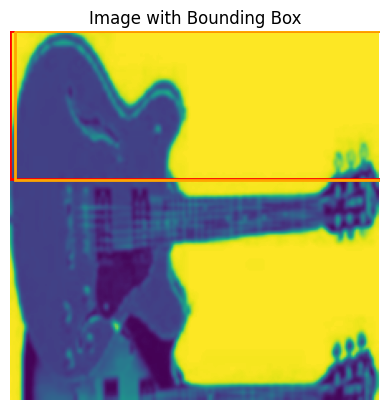

In [34]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

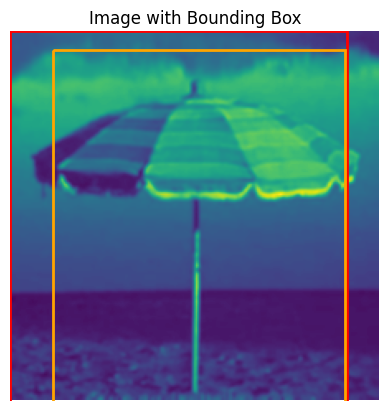

In [35]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

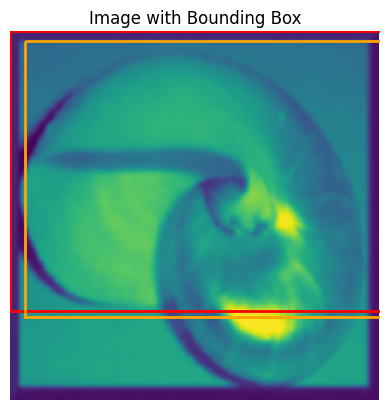

In [36]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

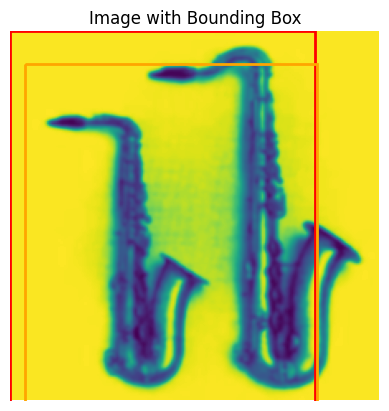

In [37]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

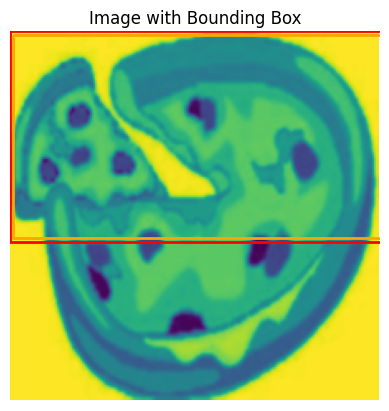

In [38]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

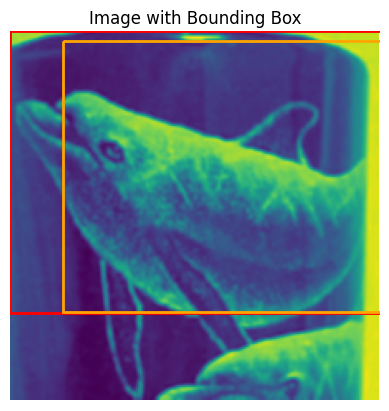

In [39]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

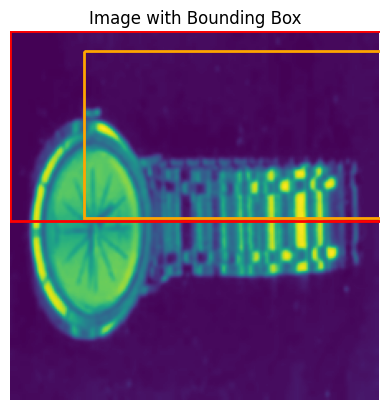

In [40]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)

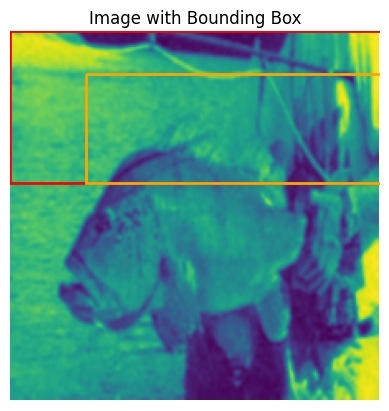

In [41]:
import random

idx = random.randint(0, len(images))

image = images[idx] * 255
image = image.reshape(224, 224)
bbox = predicted_bboxes[idx]
actual_bbox = actual_bboxes[idx]

visualize(image, bbox, actual_bbox)